In [1]:
import os
import numpy as np
import random

class Reader(object):
    def __init__(self, dataset_dir, listfile=None):
        self._dataset_dir = dataset_dir
        self._current_index = 0
        if listfile is None:
            listfile_path = os.path.join(dataset_dir, "listfile.csv")
        else:
            listfile_path = listfile
        with open(listfile_path, "r") as lfile:
            self._data = lfile.readlines()
        self._listfile_header = self._data[0]
        self._data = self._data[1:]

    def get_number_of_examples(self):
        return len(self._data)

    def random_shuffle(self, seed=None):
        if seed is not None:
            random.seed(seed)
        random.shuffle(self._data)

    def read_example(self, index):
        raise NotImplementedError()

    def read_next(self):
        to_read_index = self._current_index
        self._current_index += 1
        if self._current_index == self.get_number_of_examples():
            self._current_index = 0
        return self.read_example(to_read_index)

In [10]:
class DecompensationReader(Reader):
    def __init__(self, dataset_dir, listfile=None):
        """ Reader for decompensation prediction task.
        :param dataset_dir: Directory where timeseries files are stored.
        :param listfile:    Path to a listfile. If this parameter is left `None` then
                            `dataset_dir/listfile.csv` will be used.
        """
        Reader.__init__(self, dataset_dir, listfile)
        self._data = [line.split(',') for line in self._data]
        # print(self._data[1])
        self._data = [(x, float(t), int(stay_id) ,int(y)) for (x, t, stay_id , y) in self._data]

    def _read_timeseries(self, ts_filename, time_bound):
        ret = []
        with open(os.path.join(self._dataset_dir, ts_filename), "r") as tsfile:
            header = tsfile.readline().strip().split(',')
            assert header[0] == "Hours"
            for line in tsfile:
                mas = line.strip().split(',')
                t = float(mas[0])
                if t > time_bound + 1e-6:
                    break
                ret.append(np.array(mas))
        return (np.stack(ret), header)

    def read_example(self, index):
        """ Read the example with given index.

        :param index: Index of the line of the listfile to read (counting starts from 0).
        :return: Directory with the following keys:
            X : np.array
                2D array containing all events. Each row corresponds to a moment.
                First column is the time and other columns correspond to different
                variables.
            t : float
                Length of the data in hours. Note, in general, it is not equal to the
                timestamp of last event.
            y : int (0 or 1)
                Mortality within next 24 hours.
            header : array of strings
                Names of the columns. The ordering of the columns is always the same.
            name: Name of the sample.
        """
        if index < 0 or index >= len(self._data):
            raise ValueError("Index must be from 0 (inclusive) to number of examples (exclusive).")

        name = self._data[index][0]
        t = self._data[index][1]
        stay_id = self._data[index][2]
        y = self._data[index][3]
        (X, header) = self._read_timeseries(name, t)

        return {"X": X,
                "t": t,
                "stay_id" :  stay_id,
                "y": y,
                "header": header,
                "name": name}

class LengthOfStayReader(Reader):
    def __init__(self, dataset_dir, listfile=None):
        """ Reader for length of stay prediction task.

        :param dataset_dir: Directory where timeseries files are stored.
        :param listfile:    Path to a listfile. If this parameter is left `None` then
                            `dataset_dir/listfile.csv` will be used.
        """
        Reader.__init__(self, dataset_dir, listfile)
        self._data = [line.split(',') for line in self._data]
        self._data = [(x, float(t), int(stay_id) , float(y)) for (x, t, stay_id, y) in self._data]

    def _read_timeseries(self, ts_filename, time_bound):
        ret = []
        with open(os.path.join(self._dataset_dir, ts_filename), "r") as tsfile:
            header = tsfile.readline().strip().split(',')
            assert header[0] == "Hours"
            for line in tsfile:
                mas = line.strip().split(',')
                t = float(mas[0])
                if t > time_bound + 1e-6:
                    break
                ret.append(np.array(mas))
        return (np.stack(ret), header)

    def read_example(self, index):
        """ Reads the example with given index.

        :param index: Index of the line of the listfile to read (counting starts from 0).
        :return: Dictionary with the following keys:
            X : np.array
                2D array containing all events. Each row corresponds to a moment.
                First column is the time and other columns correspond to different
                variables.
            t : float
                Length of the data in hours. Note, in general, it is not equal to the
                timestamp of last event.
            y : float
                Remaining time in ICU.
            header : array of strings
                Names of the columns. The ordering of the columns is always the same.
            name: Name of the sample.
        """
        if index < 0 or index >= len(self._data):
            raise ValueError("Index must be from 0 (inclusive) to number of lines (exclusive).")

        name = self._data[index][0]
        t = self._data[index][1]
        stay_id = self._data[index][2]
        y = self._data[index][3]
        (X, header) = self._read_timeseries(name, t)

        return {"X": X,
                "t": t,
                "stay_id" : stay_id, 
                "y": y,
                "header": header,
                "name": name}


In [11]:
import re
import pandas as pd
from datetime import datetime, timedelta

# the way the data is read, is that all EHR data before the current timestep is included, but only the label for the current prediction time is read
# so, t is the current time step, x contains everything before that, and name is that name of the file with all timsteps and labels  
# note that the first part of the name is the subject_id not stay_id
# train_decomp_reader = DecompensationReader(dataset_dir='/scratch/fs999/shamoutlab/data/mimic-iv-extracted/decompensation/test', 
#                                     listfile='/scratch/fs999/shamoutlab/data/mimic-iv-extracted/decompensation/test_listfile.csv')
# train_decomp_reader.get_number_of_examples()

train_los_reader = LengthOfStayReader(dataset_dir='/scratch/fs999/shamoutlab/data/mimic-iv-extracted/length-of-stay/test', 
                                    listfile='/scratch/fs999/shamoutlab/data/mimic-iv-extracted/length-of-stay/test_listfile.csv')
train_los_reader.get_number_of_examples()

814736

In [ ]:
import re
import pandas as pd
from datetime import datetime, timedelta

# the way the data is read, is that all EHR data before the current timestep is included, but only the label for the current prediction time is read
# so, t is the current time step, x contains everything before that, and name is that name of the file with all timsteps and labels  
# note that the first part of the name is the subject_id not stay_id
train_los_reader = LengthOfStayReader(dataset_dir='/scratch/fs999/shamoutlab/data/mimic-iv-extracted/length-of-stay/test', 
                                    listfile='/scratch/fs999/shamoutlab/data/mimic-iv-extracted/length-of-stay/test_listfile.csv')
icu_stay_metadata = pd.read_csv('/scratch/fs999/shamoutlab/data/mimic-iv-extracted/root/all_stays.csv')
# for i in range(1,10):
#     get_item[i] = train_decomp_reader.read_example(i)
#     subject_id = re.match(r'\d+', get_item[i]['name']).group()
#     result = icu_stay_metadata[icu_stay_metadata['subject_id'] == int(subject_id)]
#     get_item[i]['intime'] = result[i]['intime'].values[0]

get_item_data = []
for i in range(0, train_los_reader.get_number_of_examples()):
    item_data = train_los_reader.read_example(i)
    subject_id = re.match(r'\d+', item_data['name']).group()
    item_data['subject_id'] = subject_id
    result = icu_stay_metadata[icu_stay_metadata['subject_id'] == int(subject_id)]
    intime = result.iloc[0]['intime']
    item_data['intime'] = intime
    
    hours = int(item_data['t'])
    date_string =  item_data['intime']
    date_format = "%Y-%m-%d %H:%M:%S"
    date_time = datetime.strptime(date_string, date_format)
    curr_time = date_time + timedelta(hours= hours)
    curr_time = curr_time.strftime(date_format)
    end_time = pd.to_datetime(curr_time)

#     print("original:", date_string)
#     print("new after adding {} hours:".format(hours), end_time)
    item_data['endtime'] = end_time
    
    get_item_data.append(item_data)

# Create DataFrame from the list of dictionaries
get_item = pd.DataFrame(get_item_data)

# print(result['intime'].values)
# get_item['X'][0:10][:,0]
get_item
#811443
# 2180-05-06,213014.53100000002

In [13]:
import re
import pandas as pd
  
test_listfile = pd.read_csv(f'/scratch/se1525/mml-ssl/decompensation/test_listfile.csv')      
test_listfile.columns = ['stay' , 'period_length' , 'stay_id' ,'y_true', 'intime' , 'outime']
test_listfile['first_part'] = test_listfile['stay'].apply(lambda x: x.split("_")[0])
test_listfile.head()

,stay,period_length,stay_id,y_true,intime,outime,first_part
0,10001884_episode1_timeseries.csv,6.0,37510196,0,2131-01-11 04:20:05,2131-01-11 10:20:05,10001884
1,10001884_episode1_timeseries.csv,7.0,37510196,0,2131-01-11 04:20:05,2131-01-11 11:20:05,10001884
2,10001884_episode1_timeseries.csv,8.0,37510196,0,2131-01-11 04:20:05,2131-01-11 12:20:05,10001884
3,10001884_episode1_timeseries.csv,9.0,37510196,0,2131-01-11 04:20:05,2131-01-11 13:20:05,10001884
4,10001884_episode1_timeseries.csv,10.0,37510196,0,2131-01-11 04:20:05,2131-01-11 14:20:05,10001884


In [ ]:
# from datetime import datetime, timedelta

# for i, row in get_item.iterrows():
#     # current_time = get_item['t'] + get_item['intime']
#     hours = int(row['t'])
#     date_string =  row['intime']
#     date_format = "%Y-%m-%d %H:%M:%S"
#     date_time = datetime.strptime(date_string, date_format)
#     curr_time = date_time + timedelta(hours= hours)
#     curr_time = curr_time.strftime(date_format)
    
#     end_time = pd.to_datetime(curr_time)

#     print("original:", date_string)
#     print("new after adding {} hours:".format(hours), end_time)



# cxr_merged_icustays_during = cxr_merged_icustays.loc[(cxr_merged_icustays.StudyDateTime>=cxr_merged_icustays.intime)&((cxr_merged_icustays.StudyDateTime<=end_time))]
# cxr_merged_icustays_during

In [41]:
get_item.to_csv('out.csv')  

In [42]:
column_dtype = get_item['subject_id'].dtype
print(column_dtype)

object


In [1]:
print_headers = True    
with open("/scratch/se1525/mml-ssl/out.csv","r") as inputfile, open("/scratch/se1525/mml-ssl/out-noduplicate.csv","w") as outputfile:
    input = inputfile.readlines()
    for row in input:
        if row[0]=="X":
            print("yes")
            if print_headers:
                outputfile.write(row)
                print_headers = False
        else:
            outputfile.write(row)

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [6]:
import pandas as pd
get_item = pd.read_csv('/scratch/se1525/mml-ssl/out.csv')
get_item.columns = ['stay' , 'period_length' , 'stay_id' ,'y_true', 'intime' , 'outime']
get_item.to_csv('los_test_listfile_with_time.csv', index = False)

In [21]:
# subject_id,hadm_id,stay_id,last_careunit,intime,outtime,los,admittime,dischtime,deathtime,ethnicity,gender,anchor_age,dod,age,mortality_inunit,mortality,mortality_inhospital
# 15406736,22159072,33859161,Medical/Surgical Intensive Care Unit (MICU/SICU),2188-09-08 23:56:39,2188-10-04 07:53:53,25.33141203703704,2188-09-08 23:55:00,2188-10-04 00:00:00,2188-10-04 00:00:00,UNKNOWN,F,69,2188-10-04 00:00:00,69,1,1,1

In [ ]:
import pandas as pd
# the metadata for the cxr contains study date and time (which are then merged to studydatetime), subject_id, and study_id
cxr_metadata = pd.read_csv('/scratch/fs999/shamoutlab/data/physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv')
print('Number of CXR images=', len(cxr_metadata))

# the metadata for the ehr contains intime (i.e. hospital), and admittime (i.e. ICU) subject_id, and study_id (admittime is discarded)
icu_stay_metadata = pd.read_csv('/scratch/fs999/shamoutlab/data/mimic-iv-extracted/root/all_stays.csv')
print('Number of ICU stays=', len(icu_stay_metadata))
columns = ['subject_id', 'stay_id', 'intime', 'outtime', 'admittime']
columns2 = ['subject_id', 'endtime']
get_item['subject_id'] = get_item['subject_id'].astype('int64')
# get_item['intime'] = get_item['intime'].astype(int)
# get_item['endtime'] = get_item['endtime'].astype(int)


# merge metadata based on subject ID
cxr_merged_icustays_old = cxr_metadata.merge(icu_stay_metadata[columns], how='inner', on='subject_id')
print(cxr_merged_icustays_old.head)
# 368350 
cxr_merged_icustays = cxr_merged_icustays_old.merge(get_item[columns2], how='inner', on='subject_id')
print(cxr_merged_icustays.head)
# 5500
out = cxr_merged_icustays_old[~cxr_merged_icustays_old['subject_id'].isin(get_item['subject_id'])]
print(out.head)
# 368295


# study datetime is for cxr images and intime/outtime are for the icu stays
# make studydatetime for cxr and reformat intime/outtime
cxr_merged_icustays['StudyTime'] = cxr_merged_icustays['StudyTime'].apply(lambda x: f'{int(float(x)):06}' )
cxr_merged_icustays['StudyDateTime'] = pd.to_datetime(cxr_merged_icustays['StudyDate'].astype(str) + ' ' + cxr_merged_icustays['StudyTime'].astype(str) ,format="%Y%m%d %H%M%S")
cxr_merged_icustays.intime=pd.to_datetime(cxr_merged_icustays.intime)
cxr_merged_icustays.outtime=pd.to_datetime(cxr_merged_icustays.outtime)
cxr_merged_icustays.endtime=pd.to_datetime(cxr_merged_icustays.endtime)

# end_time = cxr_merged_icustays.outtime
# print(cxr_merged_icustays.head)

Number of CXR images= 377110
Number of ICU stays= 59372
<bound method NDFrame.head of                                             dicom_id  subject_id  study_id  \
0       02aa804e-bde0afdd-112c0b34-7bc16630-4e384014    10000032  50414267   
1       174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962    10000032  50414267   
2       2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab    10000032  53189527   
3       e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c    10000032  53189527   
4       68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714    10000032  53911762   
...                                              ...         ...       ...   
368345  ee9155f3-944c056b-c76c73d0-3f792f2c-92ae461e    19999442  58497551   
368346  16b6c70f-6d36bd77-89d2fef4-9c4b8b0a-79c69135    19999442  58708861   
368347  58766883-376a15ce-3b323a28-6af950a0-16b793bd    19999987  55368167   
368348  7ba273af-3d290f8d-e28d0ab4-484b7a86-7fc12b08    19999987  58621812   
368349  1a1fe7e3-cbac5d93-b339aeda-86bb86b5-4f31e82e    

In [16]:
# Finally, date and times were shifted randomly into the future using an offset measured in days. 
# A single date shift was assigned to each subject_id. As a result, the data for a single patient are internally consistent. 
# For example, if the time between two measures in the database was 4 hours in the raw data, then the calculated time difference in MIMIC-IV will also be 4 hours.
# Conversely, distinct patients are not temporally comparable. That is, two patients admitted in 2130 were not necessarily admitted in the same year.
print(cxr_merged_icustays.StudyDateTime.head)

<bound method NDFrame.head of 0      2130-06-23 19:15:01
1      2130-06-23 19:15:01
2      2130-06-23 19:15:01
3      2130-06-23 19:15:01
4      2130-06-23 19:15:01
               ...        
5495   2129-05-28 13:36:18
5496   2129-05-28 13:36:18
5497   2129-05-28 13:36:18
5498   2129-05-28 13:36:18
5499   2129-05-28 13:36:18
Name: StudyDateTime, Length: 5500, dtype: datetime64[ns]>


In [42]:
first_row = get_item.iloc[0]
first_row

X             [[0.03194444444444445, , , , , , , , , 38, , ,...
t                                                             5
y                                                             0
header        [Hours, Capillary refill rate, Diastolic blood...
name                           10001884_episode1_timeseries.csv
subject_id                                             10001884
intime                                      2131-01-11 04:20:05
endtime                                     2131-01-11 09:20:05
Name: 0, dtype: object

In [44]:
cxr_merged_icustays

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,stay_id,intime,outtime,admittime,endtime,StudyDateTime
0,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 09:20:05,2130-06-23 19:15:01
1,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 10:20:05,2130-06-23 19:15:01
2,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 11:20:05,2130-06-23 19:15:01
3,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 12:20:05,2130-06-23 19:15:01
4,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 13:20:05,2130-06-23 19:15:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501101,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 12:54:45,2157-03-16 04:49:01
501102,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 13:54:45,2157-03-16 04:49:01
501103,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 14:54:45,2157-03-16 04:49:01
501104,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 15:54:45,2157-03-16 04:49:01


In [45]:
cxr_merged_icustays_during = cxr_merged_icustays.loc[((cxr_merged_icustays.StudyDateTime>=cxr_merged_icustays.intime)&(cxr_merged_icustays.StudyDateTime<=cxr_merged_icustays.endtime))]
cxr_merged_icustays_during

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,stay_id,intime,outtime,admittime,endtime,StudyDateTime
524,469d0d94-3dad5068-efac76ef-a28cc502-68fe6275,10001884,50376803,CHEST (PORTABLE AP),AP,2539,2517,21310115,044509,CHEST (PORTABLE AP),antero-posterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-15 05:20:05,2131-01-15 04:45:09
525,469d0d94-3dad5068-efac76ef-a28cc502-68fe6275,10001884,50376803,CHEST (PORTABLE AP),AP,2539,2517,21310115,044509,CHEST (PORTABLE AP),antero-posterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-15 06:20:05,2131-01-15 04:45:09
526,469d0d94-3dad5068-efac76ef-a28cc502-68fe6275,10001884,50376803,CHEST (PORTABLE AP),AP,2539,2517,21310115,044509,CHEST (PORTABLE AP),antero-posterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-15 07:20:05,2131-01-15 04:45:09
527,469d0d94-3dad5068-efac76ef-a28cc502-68fe6275,10001884,50376803,CHEST (PORTABLE AP),AP,2539,2517,21310115,044509,CHEST (PORTABLE AP),antero-posterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-15 08:20:05,2131-01-15 04:45:09
528,469d0d94-3dad5068-efac76ef-a28cc502-68fe6275,10001884,50376803,CHEST (PORTABLE AP),AP,2539,2517,21310115,044509,CHEST (PORTABLE AP),antero-posterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-15 09:20:05,2131-01-15 04:45:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501101,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 12:54:45,2157-03-16 04:49:01
501102,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 13:54:45,2157-03-16 04:49:01
501103,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 14:54:45,2157-03-16 04:49:01
501104,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 15:54:45,2157-03-16 04:49:01


In [46]:
cxr_merged_icustays_before = cxr_merged_icustays.loc[(cxr_merged_icustays.StudyDateTime<=cxr_merged_icustays.endtime)]
cxr_merged_icustays_before

,dicom_id,subject_id,study_id,PerformedProcedureStepDescription,ViewPosition,Rows,Columns,StudyDate,StudyTime,ProcedureCodeSequence_CodeMeaning,ViewCodeSequence_CodeMeaning,PatientOrientationCodeSequence_CodeMeaning,stay_id,intime,outtime,admittime,endtime,StudyDateTime
0,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 09:20:05,2130-06-23 19:15:01
1,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 10:20:05,2130-06-23 19:15:01
2,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 11:20:05,2130-06-23 19:15:01
3,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 12:20:05,2130-06-23 19:15:01
4,3892f17f-8fa034e8-e9b81865-01c48bbb-b9452626,10001884,50279568,CHEST (PA AND LAT),PA,3056,2544,21300623,191501,CHEST (PA AND LAT),postero-anterior,Erect,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,2131-01-07 20:39:00,2131-01-11 13:20:05,2130-06-23 19:15:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501101,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 12:54:45,2157-03-16 04:49:01
501102,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 13:54:45,2157-03-16 04:49:01
501103,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 14:54:45,2157-03-16 04:49:01
501104,883d9462-7ba0df08-2188db07-1c3d3b12-3b5f9695,10139117,58914658,CHEST (PORTABLE AP),AP,2544,3056,21570316,044901,CHEST (PORTABLE AP),antero-posterior,NaN,30067545,2157-03-15 22:54:45,2157-03-21 17:40:30,2157-03-09 23:25:00,2157-03-21 15:54:45,2157-03-16 04:49:01


In [47]:
print("length of file before filtering by end_time: ", len(cxr_merged_icustays))
print("length of file after filtering by end_time: ", len(cxr_merged_icustays_during))

length of file before filtering by end_time:  501106
length of file after filtering by end_time:  145841


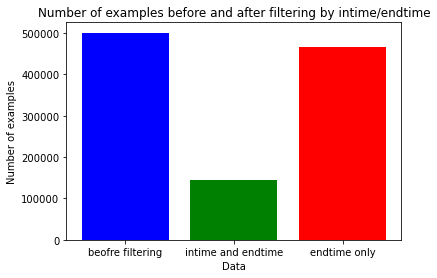

In [48]:
import matplotlib.pyplot as plt

# Data
lengths = [len(cxr_merged_icustays), len(cxr_merged_icustays_during), len(cxr_merged_icustays_before)]
labels = ['beofre filtering', 'intime and endtime', 'endtime only']

# Create bar chart
plt.bar(labels, lengths, color=['blue', 'green', 'red'])

# Add labels and title
plt.xlabel('Data')
plt.ylabel('Number of examples')
plt.title('Number of examples before and after filtering by intime/endtime')

# Show plot
plt.show()
